In [108]:

#import necessary libraries
import pandas as pd
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix,f1_score,precision_score,recall_score, accuracy_score


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/johnle/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/johnle/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


turning all uppercase to lower


In [109]:
creat_sentance = WordNetLemmatizer() #group different form of a word together so that they can be analyzed as a single item
removeW=['rt', 'retweet']
spword=set().union(stopwords.words('english'), removeW)

In [110]:
def fix_word(comment):
    
   # nword = re.sub(r"@\S+", " ", comment)  
    nword = re.sub(r"[^a-zA-Z]", " ", comment)  
    nword = nword.lower() 
    nword = nword.split()
    final_word = [i for i in nword if i not in stopwords.words('english')]
    final_sentence = [creat_sentance.lemmatize(z) for z in final_word]
    final_sentence = ' '.join(final_sentence)
    return final_sentence

In [111]:
#import the dataset
dataset = pd.read_csv('first-gop-debate.csv')
dataset = shuffle(dataset) #mix up the data though still retain logical relationships between columns
dataset.head()

,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,...,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
833,834,Chris Christie,1.0,yes,1.0,Negative,0.6662,None of the above,1.0000,NaN,...,NaN,0,NaN,NaN,Fuck it last one and I'm done #GOPDebate #Chri...,NaN,8/7/2015 9:47,6.296950e+17,"Los Angeles, CA",Pacific Time (US & Canada)
2428,2429,Ted Cruz,1.0,yes,1.0,Negative,1.0000,None of the above,0.6591,NaN,...,NaN,15,NaN,NaN,"RT @IronHide_81: Oh yes, we have to go to a ""c...",NaN,8/7/2015 9:30,6.296910e+17,NaN,Central Time (US & Canada)
1689,1690,Marco Rubio,1.0,yes,1.0,Negative,0.6640,None of the above,0.6640,NaN,...,NaN,176,NaN,NaN,RT @michellemalkin: #gopdebate fact check via ...,NaN,8/7/2015 9:38,6.296930e+17,New England,Eastern Time (US & Canada)
11010,11011,Donald Trump,1.0,yes,1.0,Negative,1.0000,FOX News or Moderators,1.0000,NaN,...,NaN,134,NaN,NaN,RT @RWSurferGirl: The candidates don't have to...,NaN,8/6/2015 19:44,6.294830e+17,NaN,NaN
13096,13097,Ben Carson,1.0,yes,1.0,Negative,1.0000,None of the above,1.0000,NaN,...,NaN,3,NaN,NaN,"RT @SupermanHotMale: Dear Dr. Ben Carson, you,...",NaN,8/6/2015 19:10,6.294750e+17,"Boston, MA",Indiana (East)


In [112]:
x = dataset.text.apply(fix_word)
y = dataset['sentiment']
print(x)

833      fuck last one done gopdebate chrischristie htt...
2428     rt ironhide oh yes go commercial break time te...
1689     rt michellemalkin gopdebate fact check via jul...
11010    rt rwsurfergirl candidate attack realdonaldtru...
13096    rt supermanhotmale dear dr ben carson sir need...
                               ...                        
2406     tellin like wonder everyone get gopdebate tcot...
12845    rt maryfolley huckabee tax plan gonna make har...
12687    rt monaeltahawy someone tell ben carson carryi...
4841     rt davidbadash chuck schumer cowardly released...
6878     look jeb coming throwing gwb bus iraq war need...
Name: text, Length: 13871, dtype: object


In [113]:
#Data Processing
vectorizer=CountVectorizer() #Encode as integers to be used for the algorithm
x_vectorized=vectorizer.fit_transform(x) #Learn the vocabulary dictionary and return document-term matrix.

In [114]:
#Split between train and test data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test= train_test_split(x_vectorized, y, test_size=0.3, random_state=0)


In [115]:
#Using decision tree
from sklearn.tree import DecisionTreeClassifier
dt=DecisionTreeClassifier(max_depth=25, criterion='gini')
#Hyperparameter Tuning using GridSearch
params = {
    'max_depth': [2, 3, 5, 10, 25],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}
gs_dt = GridSearchCV(estimator=dt, param_grid=params, cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")
gs_dt.fit(x_train, y_train)
prediction1=gs_dt.predict(x_test)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


In [116]:
#Using Logistic Regression
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(multi_class='multinomial', solver='newton-cg')
lr.fit(x_train, y_train)
#Hyperparameter Tuning using GridSearch
params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
gs_lr=GridSearchCV(lr, params, n_jobs=1, cv=5)
gs_lr.fit(x_train, y_train)
prediction2=gs_lr.predict(x_test)

In [117]:
#Multi-layer perceptron Classifier
from sklearn.neural_network import MLPClassifier
NN=MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
NN.fit(x_train, y_train)
prediction3=NN.predict(x_test);

/Users/johnle/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Text(0.5, 1.0, 'Decision Tree - Accuracy Score: 0.660')

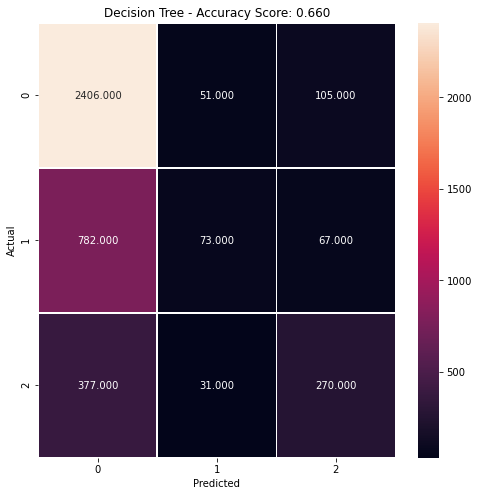

In [118]:
#Measure performance using Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

cm1=metrics.confusion_matrix(y_test, prediction1)
plt.figure(figsize=(8,8))
sns.heatmap(cm1, annot=True, fmt='0.3f', linewidth=.5)
plt.xlabel('Predicted')
plt.ylabel('Actual')
title='Decision Tree - Accuracy Score: %0.3f'%accuracy_score(y_test, prediction1)
plt.title(title, size=12)


Text(0.5, 1.0, 'Logistic Regression - Accuracy Score: 0.693')

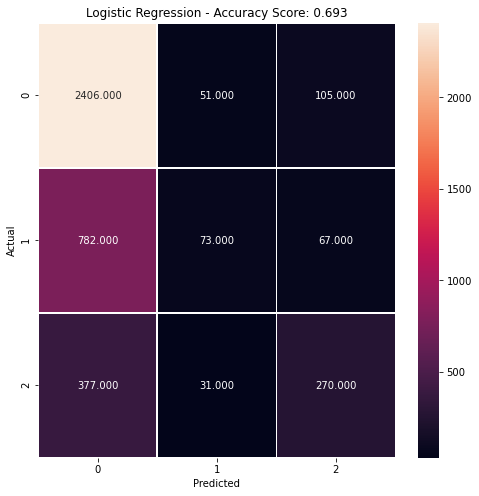

In [119]:
cm2=metrics.confusion_matrix(y_test, prediction2)
plt.figure(figsize=(8,8))
sns.heatmap(cm1, annot=True, fmt='0.3f', linewidth=.5)
plt.xlabel('Predicted')
plt.ylabel('Actual')
title='Logistic Regression - Accuracy Score: %0.3f'%accuracy_score(y_test, prediction2)
plt.title(title, size=12)


Text(0.5, 1.0, 'Neural Network - Accuracy Score: 0.645')

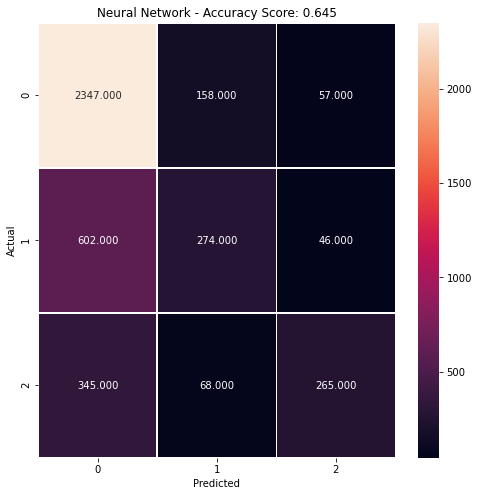

In [120]:
cm3=metrics.confusion_matrix(y_test, prediction3)
plt.figure(figsize=(8,8))
sns.heatmap(cm2, annot=True, fmt='0.3f', linewidth=.5)
plt.xlabel('Predicted')
plt.ylabel('Actual')
title='Neural Network - Accuracy Score: %0.3f'%accuracy_score(y_test, prediction3)
plt.title(title, size=12)

In [121]:
#Out of the three, logistic regression has the highest accuracy
#Run some tests with logistic regression model
test_feature = vectorizer.transform([' this have being a very good day love the weather today'])
gs_lr.predict(test_feature)

array(['Positive'], dtype=object)

In [122]:
test_feature = vectorizer.transform(['i am alright'])
gs_lr.predict(test_feature)

array(['Negative'], dtype=object)

In [123]:
test_feature = vectorizer.transform(['i hate this president he is not good'])
gs_lr.predict(test_feature)

array(['Negative'], dtype=object)